## Vulnerability analysis

This notebook contains analysis of vulnerabilities in Common Criteria certificates. 

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
from pathlib import Path
import shutil

plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = [8, 5]

from sec_certs.dataset.common_criteria import CCDataset
import datetime

import itertools
from sec_certs.dataset.cve import CVEDataset
from sec_certs.dataset.common_criteria import CCDatasetMaintenanceUpdates

pd.set_option("display.max_colwidth", 100)

## Retrieve necessary objects from sec-certs

In [2]:
# Local instantiation
dset: CCDataset = CCDataset.from_json('/Users/adam/phd/projects/certificates/datasets/cc_full_dataset/CommonCriteria_dataset.json')
main_dset = CCDatasetMaintenanceUpdates.from_json('/Users/adam/phd/projects/certificates/datasets/cc_full_dataset/certs/maintenance/Maintenance updates.json')
cve_dset: CVEDataset = dset._prepare_cve_dataset()

# Fully remote instantiation
# dset: CCDataset = CCDataset.from_web_latest()
# main_dset: CDatasetMaintenanceUpdates = CCDatasetMaintenanceUpdates.from_web_latest()
# cve_dset: CVEDataset = CVEDataset.from_web()

parsing cpe matching (by NIST) dictionary: 100%|██████████| 361174/361174 [00:27<00:00, 13106.33it/s]
Building-up lookup dictionaries for fast CVE matching: 100%|██████████| 172913/172913 [00:12<00:00, 14407.46it/s]


## Define some helper functions

In [3]:
def find_earliest_after_cve(row):
    "Given dataframe row, will return first maintenance date succeeding first published CVE related to a certificate if exists, else np.nan"
    if isinstance(row['earliest_cve'], float):
        return np.nan
    maintenances_after_cve = list(filter(lambda x: x > row['earliest_cve'], row['maintenance_dates']))
    return min(maintenances_after_cve) if maintenances_after_cve else np.nan

## Preprocess dataset of Common Criteria certificates

In [4]:
df = dset.to_pandas()
df = df.loc[~df.manufacturer.isnull()] # Manually delete one certificate with None manufacturer (seems to have many blank fields)

# # Introduce highest security level EAL variable
eals = ['EAL1', 'EAL1+', 'EAL2', 'EAL2+', 'EAL3', 'EAL3+', 'EAL4', 'EAL4+', 'EAL5', 'EAL5+', 'EAL6+', 'EAL7', 'EAL7+']
df['highest_security_level'] = df.security_level.map(lambda all_levels: [eal for eal in all_levels if eal.startswith('EAL')] if all_levels else np.nan)
df.highest_security_level = df.highest_security_level.map(lambda x: x[0] if x and isinstance(x, list) else np.nan)
df.highest_security_level = pd.Categorical(df.highest_security_level, categories=eals, ordered=True)

# Introduce year when cert got valid
df['year_from'] = pd.DatetimeIndex(df.not_valid_before).year

## Preprocess dataset of maintenance updates

In [5]:
main_df = main_dset.to_pandas()
main_df.maintenance_date = main_df.maintenance_date.dt.date

# Recover number of maintenances
n_maintenances = main_df.groupby('related_cert_digest').name.count()
n_maintenances.index.name = 'dgst'
n_maintenances = n_maintenances.rename('n_maintenances')

if 'n_maintenances' not in df.columns:
    df = pd.concat([df, n_maintenances], axis='columns')
    df.n_maintenances = df.n_maintenances.fillna(0).astype('int32')

# # Recover dates of maintenance updates
main_dates = main_df.copy()
main_dates.maintenance_date = main_df.maintenance_date.map(lambda x: [x])
main_dates = main_dates.groupby('related_cert_digest').maintenance_date.agg('sum').rename('maintenance_dates')
main_dates.index.name = 'dgst'

if 'maintenance_dates' not in df.columns:
    df = pd.concat([df, main_dates], axis='columns')

## Process CVE dataset and enrich CC DataFrame with CVE-related columns

In [6]:
# Build CVE dataset
cves = list(itertools.chain.from_iterable([x.heuristics.related_cves for x in dset if x.heuristics.related_cves]))
cve_dict = {x: cve_dset[x] for x in cves}
cve_dset.cves = cve_dict
cve_df = cve_dset.to_pandas()

# # Get some auxillary columns related to CVEs
df['n_cves'] = df.related_cves.map(lambda x: len(x) if x is not np.nan else 0)
df['cve_published_dates'] = df.related_cves.map(lambda x: [cve_dset[y].published_date.date() for y in x] if x is not np.nan else np.nan)
df['earliest_cve'] = df.cve_published_dates.map(lambda x: min(x) if isinstance(x, list) else np.nan)
df['worst_cve'] = df.related_cves.map(lambda x: max([cve_dset[cve].impact.base_score for cve in x]) if x is not np.nan else np.nan)

In [7]:
# Take a look at columns related to CVEs
df.loc[~df.related_cves.isna(), ['related_cves', 'cve_published_dates', 'earliest_cve', 'worst_cve']]

,related_cves,cve_published_dates,earliest_cve,worst_cve
c4bd865f2ae51533,[CVE-2019-5408],[2019-08-09],2019-08-09,6.5
b9f476ad0695d397,[CVE-2021-20740],[2021-06-28],2021-06-28,8.8
ebd276cca70fd723,"[CVE-2013-5420, CVE-2013-5421, CVE-2013-6745, CVE-2015-0235, CVE-2017-1732, CVE-2019-4513]","[2013-12-23, 2013-12-22, 2013-12-22, 2015-01-28, 2018-08-17, 2019-08-26]",2013-12-22,10.0
7a53ce3f91bf73c7,"[CVE-2017-14799, CVE-2017-14800, CVE-2017-14801, CVE-2017-14802, CVE-2017-9276]","[2018-03-01, 2018-03-01, 2018-03-02, 2018-03-02, 2018-03-02]",2018-03-01,6.1
ac5e56e41a0b950e,"[CVE-2018-13367, CVE-2019-15703, CVE-2019-17655, CVE-2019-17656, CVE-2019-5591, CVE-2020-12812, ...","[2019-08-23, 2019-10-24, 2020-06-16, 2021-04-12, 2020-08-14, 2020-07-24, 2020-09-24, 2021-03-04,...",2019-08-23,9.8
...,...,...,...,...
48e7e9d2282c61b3,[CVE-2021-35469],[2021-07-14],2021-07-14,7.8
ffeef32299d913d6,"[CVE-2008-1130, CVE-2008-1592, CVE-2009-0439]","[2008-03-04, 2008-03-31, 2009-02-24]",2008-03-04,7.2
a092aebf5a286ded,[CVE-2004-2558],[2004-12-31],2004-12-31,7.5
ace069b9b7c10f19,[CVE-2000-0772],[2000-10-20],2000-10-20,7.5


## Plot distribution of categories in CPE-rich vs. all certificates

<AxesSubplot:title={'center':'Categories (without smartcards) comparison between CPE-rich, CVE-rich and all certificates'}>

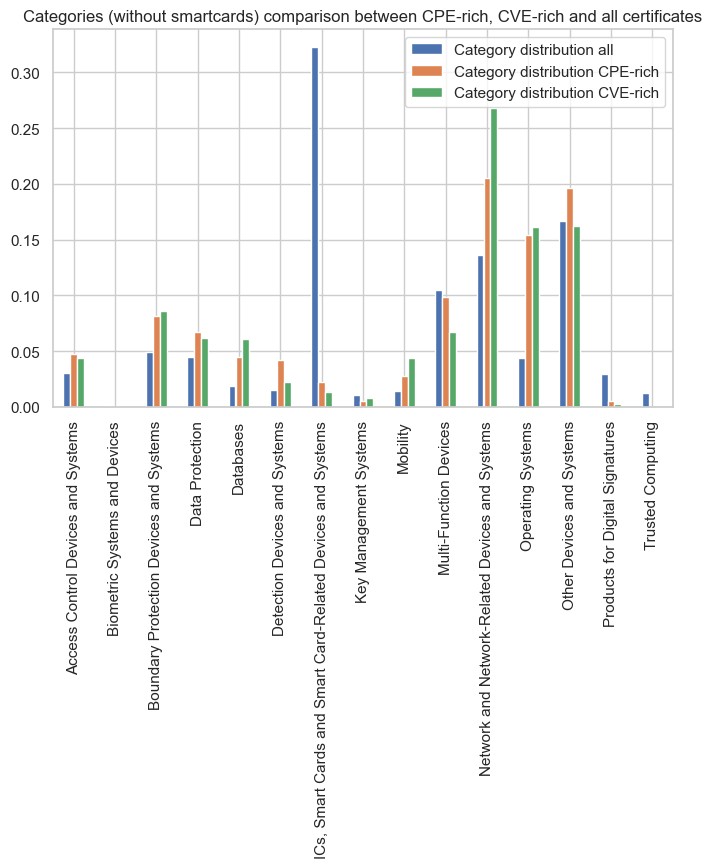

In [80]:
df_cpe_rich = df.loc[~df.verified_cpe_matches.isnull()].copy()
df_cve_rich = df.loc[df.n_cves > 0].copy()

categories_cpe = df_cpe_rich.category.value_counts().sort_index().rename('Category distribution CPE-rich')
categories_cve = df_cve_rich.category.value_counts().sort_index().rename('Category distribution CVE-rich')
categories_all = df.category.value_counts().sort_index().rename('Category distribution all')

categories_merged = pd.concat([categories_all, categories_cpe, categories_cve], axis=1)
categories_merged = categories_merged.div(categories_merged.sum(axis=0), axis=1)
categories_merged.plot.bar(title='Categories (without smartcards) comparison between CPE-rich, CVE-rich and all certificates')

## Plot distribution of years in CPE-rich, CVE-rich, and all certificates

<AxesSubplot:title={'center':'Years comparision between CPE-rich, CVE-rich and all certificates'}>

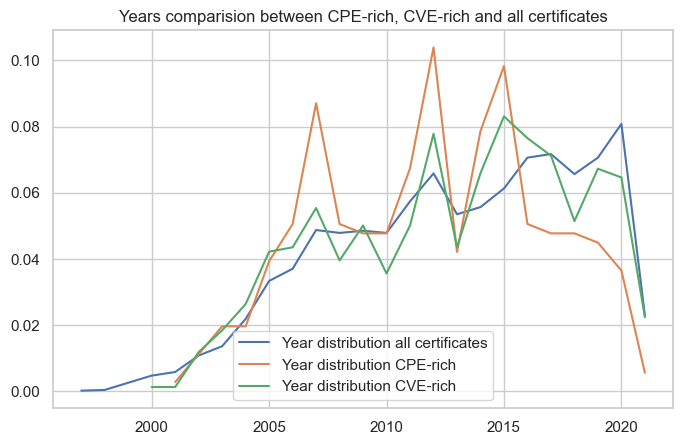

In [81]:
years_cpe = df_cpe_rich.year_from.value_counts().sort_index().rename('Year distribution CPE-rich')
years_cve = df_cve_rich.year_from.value_counts().sort_index().rename('Year distribution CVE-rich')
years_all = df.year_from.value_counts().sort_index().rename('Year distribution all certificates')

years_merged = pd.concat([years_all, years_cpe, years_cve], axis=1)
years_merged = years_merged.div(years_merged.sum(axis=0), axis=1)
years_merged.plot.line(title='Years comparision between CPE-rich, CVE-rich and all certificates')

## Plot distribution of security levels in CPE-rich, CVE-rich and all certificates

<AxesSubplot:title={'center':'Highest security level comparision between CPE-rich, CVE-rich and all certificates'}>

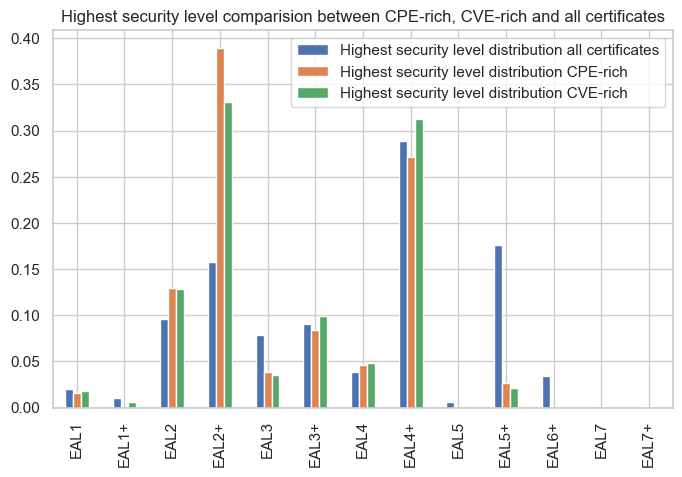

In [82]:
levels_cpe = df_cpe_rich.highest_security_level.value_counts().sort_index().rename('Highest security level distribution CPE-rich')
levels_cve = df_cve_rich.highest_security_level.value_counts().sort_index().rename('Highest security level distribution CVE-rich')
levels_all = df.highest_security_level.value_counts().sort_index().rename('Highest security level distribution all certificates')

levels_merged = pd.concat([levels_all, levels_cpe, levels_cve], axis=1)
levels_merged = levels_merged.div(levels_merged.sum(axis=0), axis=1)
levels_merged.plot.bar(title='Highest security level comparision between CPE-rich, CVE-rich and all certificates')

## Plot distribution of most common (top 20) vendors in CPE-rich, CVE-rich and all certificates

<AxesSubplot:title={'center':'Common vendors comparison between CPE-rich, CVE-rich and all certificates'}>

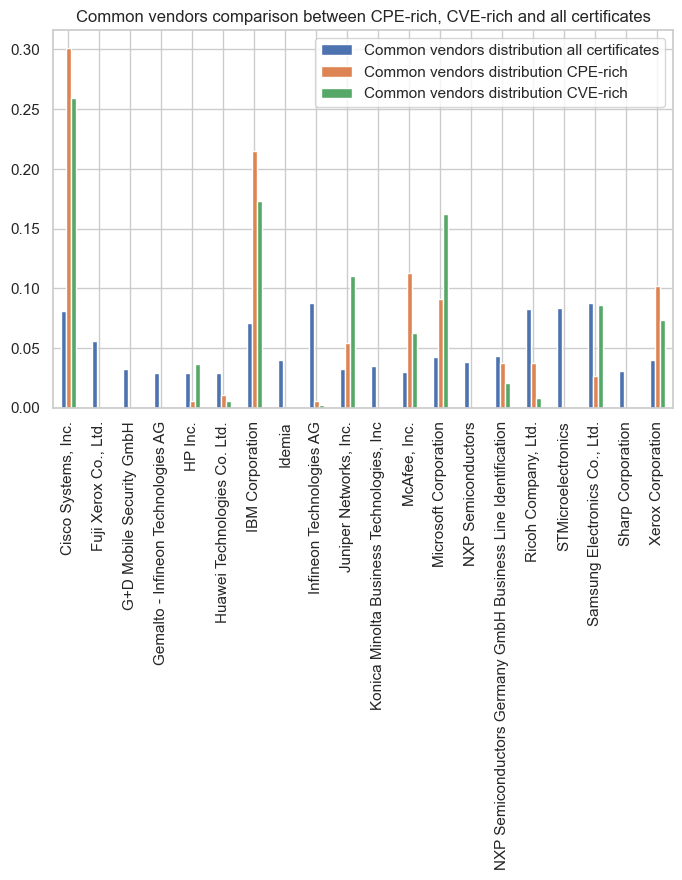

In [83]:
top_manufacturers = list(df.manufacturer.value_counts().head(20).index)
vendors_cpe = df_cpe_rich.loc[df_cpe_rich.manufacturer.isin(top_manufacturers), 'manufacturer'].value_counts().sort_index().rename('Common vendors distribution CPE-rich')
vendors_cve = df_cve_rich.loc[df_cve_rich.manufacturer.isin(top_manufacturers), 'manufacturer'].value_counts().sort_index().rename('Common vendors distribution CVE-rich')
vendors_all = df.loc[df.manufacturer.isin(top_manufacturers), 'manufacturer'].value_counts().sort_index().rename('Common vendors distribution all certificates')

vendors_merged = pd.concat([vendors_all, vendors_cpe, vendors_cve], axis=1)
vendors_merged = vendors_merged.div(vendors_merged.sum(axis=0), axis=1)
vendors_merged.plot.bar(title='Common vendors comparison between CPE-rich, CVE-rich and all certificates')

## Basic correlations between security level and CVEs

In [84]:
# Compute correlation of security level and number of cves
# Only very weak correlation found, higher level => less CVEs, definitely not conclusive, just for our information
print(f'Correlation between security level and number of CVES: {df.highest_security_level.cat.codes.corr(df.n_cves)}')
print(f'Correlation between security level and number of CVEs (excluding vulnerability-free certs): {df_cve_rich.highest_security_level.cat.codes.corr(df_cve_rich.n_cves)}')

# Compute correlation of security level and the base-score of the worst CVE
print(f'Correlation between security level and the worst CVE (excluding vulnerability-free certs): {df_cve_rich.highest_security_level.cat.codes.corr(df.worst_cve)}')

Correlation between security level and number of CVES: -0.10419188582272582
Correlation between security level and number of CVEs (excluding vulnerability-free certs): -0.11196590058883345
Correlation between security level and the worst CVE (excluding vulnerability-free certs): -0.07045231825033621


## Correlation between more specific SAR levels and CVEs
The info related to SARs can be found at: https://www.commoncriteriaportal.org/files/ccfiles/CCPART3V3.1R5.pdf

In [165]:
# Stuff related to SAR parsing
sar_ate = {'ATE_COV': 3, 'ATE_DPT': 4, 'ATE_FUN': 2, 'ATE_IND': 3}
sar_ava = {'AVA_VAN': 5}
sar_aco = {'ACO_VUL': 3}
sar_alc = {'ALC_FLR': 3}
sar_ase = {'ASE_INT': 1, 'ASE_CCL': 1, 'ASE_SPD': 1, 'ASE_OBJ': 2, 'ASE_ECD': 1, 'ASE_REQ': 2, 'ASE_TSS': 2}
all_sar_keys = list(sar_ate.keys()) + list(sar_ava.keys()) + list(sar_alc.keys()) +list(sar_ase.keys())

def get_sar_level(dset, dgst, sar_key):
    """
    Will get SAR level out of certificate.
    """
    def dct_get_sar_level(keyword_dict):
        if not keyword_dict:
            return np.nan

        viable_keys = [x for x in keyword_dict['rules_security_assurance_components'].keys() if sar_key in x]
        viable_keys = [int(x.split('.')[1]) for x in viable_keys if '.' in x]
        return max(viable_keys) if viable_keys else np.nan

    report_level = dct_get_sar_level(dset[dgst].pdf_data.report_keywords) if dset[dgst].pdf_data.report_keywords else np.nan
    st_level = dct_get_sar_level(dset[dgst].pdf_data.st_keywords) if dset[dgst].pdf_data.st_keywords else np.nan
    if report_level == np.nan and st_level == np.nan:
        return np.nan
    else:
        return max(report_level, st_level)

# Compute correlations between SAR and number of CVEs or Worst CVE respectively
df_cve_sar = df_cve_rich.loc[:, ['highest_security_level', 'cve_published_dates', 'earliest_cve', 'worst_cve', 'n_cves']].copy()
df_cve_sar.index.name = 'dgst'
for sar in all_sar_keys:
    df_cve_sar[sar] = df_cve_sar.apply(lambda x: get_sar_level(dset, x.name, sar), axis=1)
    print(f'Correlation ({sar}, n_cves): {df_cve_sar[sar].corr(df_cve_sar.n_cves)}, (support {df_cve_sar[sar].count()})')
    print(f'Correlation ({sar}, worst CVE score): {df_cve_sar[sar].corr(df_cve_sar.worst_cve)}\n')

Correlation (ATE_COV, n_cves): 0.132798380772924, (support 425)
Correlation (ATE_COV, worst CVE score): -0.054886987749844574

Correlation (ATE_DPT, n_cves): 0.034317244801649334, (support 237)
Correlation (ATE_DPT, worst CVE score): -0.12838941167307333

Correlation (ATE_FUN, n_cves): 0.0875143736138674, (support 430)
Correlation (ATE_FUN, worst CVE score): -0.09659621475508744

Correlation (ATE_IND, n_cves): -0.04412314548757147, (support 478)
Correlation (ATE_IND, worst CVE score): -0.03743162032691404

Correlation (AVA_VAN, n_cves): 0.0013216394375797677, (support 329)
Correlation (AVA_VAN, worst CVE score): -0.06746364678999538

Correlation (ALC_FLR, n_cves): 0.11089990197775774, (support 407)
Correlation (ALC_FLR, worst CVE score): -0.02864608579340732

Correlation (ASE_INT, n_cves): nan, (support 273)
Correlation (ASE_INT, worst CVE score): nan

Correlation (ASE_CCL, n_cves): nan, (support 250)
Correlation (ASE_CCL, worst CVE score): nan

Correlation (ASE_SPD, n_cves): nan, (sup

## Plot time distribution of CVEs w.r.t. to date when certificate gets certified

TODO: This plot is a crap, as it can be generated by two certs. alone (one that has vulns before certification, other that has vulns after certification). We should introduce some locality

The following plot describes number of CVEs over whole dataset depending on their release date. on x axis, 0 denotes the date when a certificate was certified (`not_valid_before` field). Each tick on x axis is a month in the timeline. Thus, -10 on x-axis shows proportion of vulnerabilities described generally 10 months before certifying a device. Similarly for 7, number of vulns. disclosed 7 months after certification is displayed

Text(2.3194444444444446, 0.5, 'Number of released CVEs')

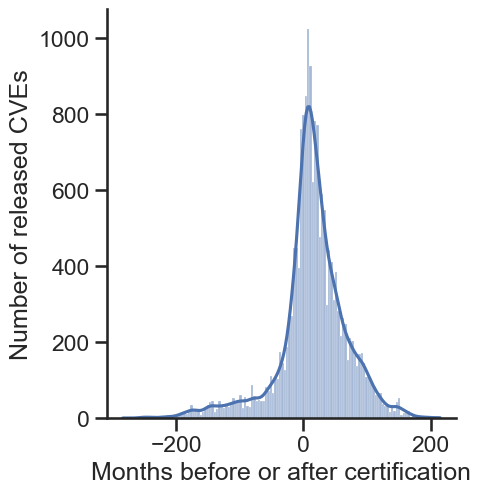

In [167]:
# Get vuln_n_months_from_release variable that holds a list of months where CVEs were released before or after certification.
def get_month_difference(lst, dt):
    def find_diff(x, y):
        return (x.year - y.year) * 12 + (x.month - y.month)
    return [find_diff(x, dt) for x in lst]

df_cve_rich['vuln_n_months_from_release'] = df_cve_rich.apply(lambda x: get_month_difference(x['cve_published_dates'], x['not_valid_before']), axis=1)
# Drop the (20) extreme values that hold too many vulnerabilities
cuttof_cves = df_cve_rich.sort_values(by='n_cves', ascending=False)[20:].copy()
month_data = list(itertools.chain.from_iterable(cuttof_cves['vuln_n_months_from_release'].tolist()))

ax = sns.displot(month_data, kde=True)
plt.xlabel("Months before or after certification")
plt.ylabel("Number of released CVEs")

In [89]:
df_cve_rich.head()

,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,st_link,...,indirectly_affecting,highest_security_level,year_from,n_maintenances,maintenance_dates,n_cves,cve_published_dates,earliest_cve,worst_cve,vuln_n_months_from_release
c4bd865f2ae51533,"HP XP7 Device Manager Software, HP XP7 Tiered Storage Manager Software 8.0.1-02",active,Access Control Devices and Systems,Hewlett Packard Enterprise Company,JP,"[ALC_FLR.1, EAL2+]",2017-07-31,2022-07-31,https://www.commoncriteriaportal.org/files/epfiles/c0567_erpt.pdf,https://www.commoncriteriaportal.org/files/epfiles/c0567_est.pdf,...,NaN,EAL2+,2017,0,NaN,1,[2019-08-09],2019-08-09,6.5,[25]
b9f476ad0695d397,"Hitachi Virtual Storage Platform G1000, Hitachi Virtual Storage Platform VX7 Control Program 80-...",active,Access Control Devices and Systems,"Hitachi, Ltd.",JP,"[ALC_FLR.1, EAL2+]",2016-06-06,2021-06-06,https://www.commoncriteriaportal.org/files/epfiles/c0514_erpt.pdf,https://www.commoncriteriaportal.org/files/epfiles/c0514_est.pdf,...,NaN,EAL2+,2016,0,NaN,1,[2021-06-28],2021-06-28,8.8,[60]
ebd276cca70fd723,IBM Security Access Manager for Enterprise Single Sign-On Version 8.2,active,Access Control Devices and Systems,IBM Corporation,DE,"[ALC_FLR.1, EAL3+]",2014-12-05,NaT,https://www.commoncriteriaportal.org/files/epfiles/0683a_pdf.pdf,https://www.commoncriteriaportal.org/files/epfiles/0683b_pdf.pdf,...,NaN,EAL3+,2014,0,NaN,6,"[2013-12-23, 2013-12-22, 2013-12-22, 2015-01-28, 2018-08-17, 2019-08-26]",2013-12-22,10.0,"[-12, -12, -12, 1, 44, 56]"
7a53ce3f91bf73c7,NetIQ Access Manager 4.0,active,Access Control Devices and Systems,NetIQ Corporation,SE,"[ALC_FLR.1, EAL3]",2014-09-17,NaT,https://www.commoncriteriaportal.org/files/epfiles/Certification%20Report%20NetIQ%20Access%20man...,https://www.commoncriteriaportal.org/files/epfiles/NetIQ%20Access%20Manager%20EAL3%20ST%20v1-13....,...,NaN,EAL3,2014,0,NaN,5,"[2018-03-01, 2018-03-01, 2018-03-02, 2018-03-02, 2018-03-02]",2018-03-01,6.1,"[42, 42, 42, 42, 42]"
ac5e56e41a0b950e,Fortinet FortiGate/FortiOS 6.0.9,active,Boundary Protection Devices and Systems,"Fortinet, Inc.",CA,[],2021-01-05,2026-01-05,https://www.commoncriteriaportal.org/files/epfiles/497%20LSS%202019%20CR.pdf,https://www.commoncriteriaportal.org/files/epfiles/497%20LSS%202019%20ST%20v1.1.pdf,...,NaN,NaN,2021,0,NaN,10,"[2019-08-23, 2019-10-24, 2020-06-16, 2021-04-12, 2020-08-14, 2020-07-24, 2020-09-24, 2021-03-04,...",2019-08-23,9.8,"[-17, -15, -7, 3, -5, -6, -4, 2, -3, 7]"


## Time from CVE to maintenance update

The following block computes time from CVE to maintenance update of a certificate. Though, it has some limitations:
- So far we only watch for first CVE related to a certified product (though most of certificates have only one maintenance anyway, if they even have one)
- We assume that a maintance update released *after* (by date comparison) CVE fixes that vulnerability
- The sample size is small. Only 36 certificates have at least one CVE and at least one Maintenance update. Out of those, only 23 certificates have maintenance update that comes after a CVE
- Some stats is shown below, the quantiles in the number of days that it takes to fix the CVE are (267, 382, 562)
- Many certificates have some CVE (167) that is not fixed in a form of a maintenance update
- Last snippet of this block copies the identified maintenance updates into just created folder, so that they can be manually investigated. The assumption is that the `dset` dataset holds the files related to maintenance updates.

In [91]:
# Compute how many vulnerable certs have 0 or >0 maintenance updates
n_unfixed_certs = df.loc[(df.n_cves>0) & (df.n_maintenances==0)].shape[0]
n_fixed_certs = df.loc[(df.n_cves>0) & (df.n_maintenances>0)].shape[0]
print(f'Number of certificates with >0 CVEs but 0 maintenance reports: {n_unfixed_certs}')
print(f'Number of certificates with >0 CVEs and >0 maintenance reports: {n_fixed_certs}')

# Compute earlierst maintenance that comes after some CVE, compute time to fix
df_fixed = df.loc[(df.n_cves > 0) & (df.n_maintenances > 0)].copy()
df_fixed.loc[:, 'earliest_maintenance'] = df_fixed.apply(find_earliest_after_cve, axis=1)
df_fixed.loc[:, 'time_to_fix_cve'] = df_fixed.earliest_maintenance - df_fixed.earliest_cve

print(df_fixed.loc[~df_fixed.time_to_fix_cve.isnull()]['time_to_fix_cve'].describe())

Number of certificates with >0 CVEs but 0 maintenance reports: 651
Number of certificates with >0 CVEs and >0 maintenance reports: 107
count                              86
mean     1320 days 08:05:34.883720928
std      1271 days 19:39:45.527318128
min                  12 days 00:00:00
25%                 377 days 18:00:00
50%                 691 days 12:00:00
75%                2327 days 18:00:00
max                5161 days 00:00:00
Name: time_to_fix_cve, dtype: object


In [92]:
df_fixed.time_to_fix_cve

822d871f3bbd06d7    374 days
8a5e6bcda602920c    417 days
1675828cce75140b   2920 days
0b494b3a447bfc50   2575 days
318dcee9d8f6ac99    295 days
                      ...   
32eebb87bd1c27d6         NaT
17006cbc914ff7e1         NaT
8a3ca0abcdb5a6c3         NaT
bf0f130ebce2e124    127 days
5f1df5ad8e51ba75   2602 days
Name: time_to_fix_cve, Length: 107, dtype: timedelta64[ns]

In [ ]:
# TODO: Only 75 files are found, 11 are missing. What they are?
# This cell copies files that should fix vulns into special folder

# This snippet will get filenames of all maintenance updates that are assumed to fix a vulnerability (for manual investigation)
fixed_dgsts = df_fixed.index[~df_fixed.time_to_fix_cve.isna()].tolist()
fixed_dates = df_fixed.loc[~df_fixed.time_to_fix_cve.isna(), 'earliest_maintenance'].tolist()
tuples = set(zip(fixed_dgsts, fixed_dates))
main_df['vulnerability_key'] = list(zip(main_df.related_cert_digest, main_df.maintenance_date))
main_files = main_df.index[main_df.vulnerability_key.isin(tuples)].tolist()  # <-- Here are the filenames

txt_dir = dset.certs_dir / 'maintenance/reports/txt'
pdf_dir = dset.certs_dir / 'maintenance/reports/pdf'
txt_destination = Path('./maintenance_updates_that_should_fix_vulns/txt').resolve()
pdf_destination = Path('./maintenance_updates_that_should_fix_vulns/pdf').resolve()

txt_destination.mkdir(parents=True, exist_ok=True)
pdf_destination.mkdir(parents=True, exist_ok=True)

set_fixed_reports = set(main_files)
for report in pdf_dir.iterdir():
    if report.name.strip('.pdf') in set_fixed_reports:
        dst = pdf_destination / report.name
        shutil.copy(report, dst)
for report in txt_dir.iterdir():
    if report.name.strip('.txt') in set_fixed_reports:
        dst = txt_destination / report.name
        shutil.copy(report, dst)

/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 43.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/seaborn/cat

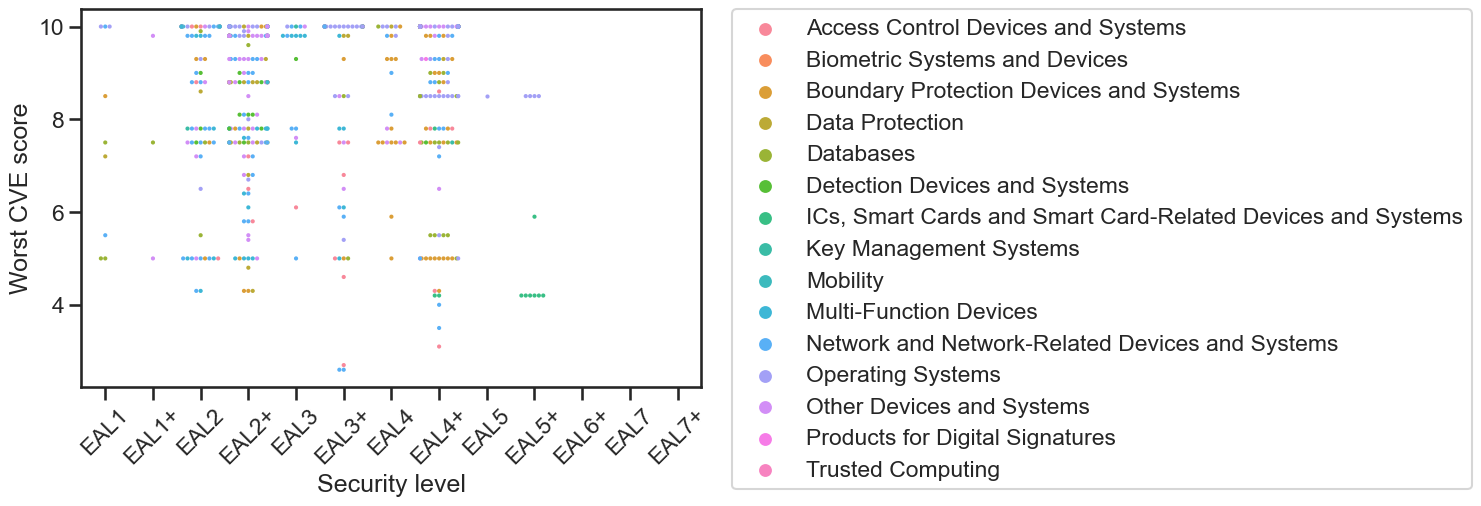

In [94]:
# Scatter plot of vulnerabilities. X axis: Security level, Y axis: Highest score of affecting vulns. Color: Category.
df_plot = df_cve_rich.loc[~df_cve_rich.highest_security_level.isna()].copy()
level_numbers = {x: y for x, y in zip(eals, range(len(eals)))}
df_plot['highest_security_level_number'] = df.highest_security_level.map(level_numbers)
sns.set_theme(style="whitegrid")
sns.set(style='ticks', context='talk')

g = sns.swarmplot('highest_security_level', 'worst_cve', data=df_plot, s=3, hue='category')
g = g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.xlabel("Security level")
plt.ylabel("Worst CVE score")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [182]:
# TODO: Only 75 files are found, 11 are missing. What they are?
# This cell copies files that should fix vulns into special folder

# This snippet will get filenames of all maintenance updates that are assumed to fix a vulnerability (for manual investigation)
fixed_dgsts = df_fixed.index[~df_fixed.time_to_fix_cve.isna()].tolist()
fixed_dates = df_fixed.loc[~df_fixed.time_to_fix_cve.isna(), 'earliest_maintenance'].tolist()
tuples = set(zip(fixed_dgsts, fixed_dates))
main_df['vulnerability_key'] = list(zip(main_df.related_cert_digest, main_df.maintenance_date))
main_files = main_df.index[main_df.vulnerability_key.isin(tuples)].tolist()  # <-- Here are the filenames

txt_dir = dset.certs_dir / 'maintenance/reports/txt'
pdf_dir = dset.certs_dir / 'maintenance/reports/pdf'
txt_destination = Path('./maintenance_updates_that_should_fix_vulns/txt').resolve()
pdf_destination = Path('./maintenance_updates_that_should_fix_vulns/pdf').resolve()

txt_destination.mkdir(parents=True, exist_ok=True)
pdf_destination.mkdir(parents=True, exist_ok=True)

set_fixed_reports = set(main_files)
for report in pdf_dir.iterdir():
    if report.name.strip('.pdf') in set_fixed_reports:
        dst = pdf_destination / report.name
        shutil.copy(report, dst)
for report in txt_dir.iterdir():
    if report.name.strip('.txt') in set_fixed_reports:
        dst = txt_destination / report.name
        shutil.copy(report, dst)